In [1]:
# !pip install numpy
# !pip install pandas
# !pip install tqdm
# !pip install sklearn
# !pip install matplotlib

In [2]:
# import required libraries
import datetime
import math
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
NUM_TIME_SLOTS = 144 # 10 min per slot
NUM_DAYS_IN_DATA = 0
FEATURES = []

In [3]:
# 24 hours is divided into 144 slots where each slot is 10 mins long
def calculateTimeSlot(time,printValue=True):                        # used to get timeslot from time
    global NUM_TIME_SLOTS
    dateTime = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')    # string to datetime
    timePart = dateTime.time()
    timeInMinutes = (timePart.hour * 60) + timePart.minute + (timePart.second/60) + 1   # time in minutes
    timeSlot = timeInMinutes/10
    roundedTimeSlot = math.ceil(timeSlot)
    if roundedTimeSlot > NUM_TIME_SLOTS:
        roundedTimeSlot -= 1
    if printValue==True:
        print(f"time: {time} timeInMinutes: {timeInMinutes} timeSlot: {roundedTimeSlot}")
    return int(roundedTimeSlot)

def extractDayOfWeek(time):                                    # day of week from time
    d = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return d.weekday()

def extractDate(time):                               # date from time
    d = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return str(d.date())

print(type(extractDate('2019-01-01 00:00:00')))

<class 'str'>


In [4]:
def extractNumberOfPOI(poiArray):             # number of POI from POI array simple count
    poiCount = 0
    for poiEntry in poiArray:           
        poiEntry = poiEntry + ':'
        divisions = poiEntry.split(":") # split using :
        poiCount += int(divisions[1])   # add the count to poiCount for each POI entry
    return poiCount
        

In [5]:
def readMultipleData(path,fileNamePrefix,headerNames,dataTypes,delimiter2="\t"):        # read multiple files from path and ignore mac files
    global NUM_DAYS_IN_DATA
    filesToExplore = []
    for file in os.listdir(path):               # read all files in path
        if file.startswith(fileNamePrefix):
            filesToExplore.append(file)
            # print(f"{file} read")
        else:                           
            continue

    print(f"{len(filesToExplore)} files read")
    if fileNamePrefix == 'order':   # ignore mac files
        NUM_DAYS_IN_DATA = len(filesToExplore) # get number of days in data using file count
    
    readData = []
    for files in filesToExplore:        # read each file
        fileRead = pd.read_csv(path + files, sep=delimiter2, names=headerNames,dtype=dataTypes)
        readData.append(fileRead)

    readData = pd.concat(readData, ignore_index=True) # concat all data to dataframe
    return readData

In [6]:
def extractTime(time):        # extract time from time i.e remove date
    time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    timePart = time.time()
    return str(timePart)

In [7]:
# now read region Data
regionData = pd.read_csv('./training_data/cluster_map/cluster_map', sep='\t', names=['region_hash', 'region_id'],dtype={'region_hash': 'str', 'region_id': 'int'})


In [8]:
def getRegionId(regionHash):    # fetch region id from region hash after iterating through region data
    for _, row in regionData.iterrows():
        if row['region_hash'] == regionHash:
            return row['region_id']

In [9]:
# read order data and store in orderData
dataTypes = {'order_id':'str', 'driver_id':'str', 'passenger_id':'str', 'start_region_hash':'str', 'dest_region_hash':'str', 'price':'double', 'time':'str'}
orderDataPath = './training_data/order_data/'
orderData = readMultipleData(orderDataPath,'order', ['order_id', 'driver_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'price', 'time'], dataTypes)
print("printing order data")
# print(orderData.head())


21 files read
printing order data


In [10]:
# read weather data and store in weatherData
dataTypes={'time':'str', 'weather':'int', 'temperature':'double', 'PM2.5':'double'}
weatherDataPath = './training_data/weather_data/'
weatherData = readMultipleData(weatherDataPath,'weather', ['time', 'weather', 'temperature', 'PM2.5'], dataTypes)
print("printing weather data")
# print(weatherData.head())

21 files read
printing weather data


In [11]:
weatherData['time_slot'] = weatherData['time'].apply(calculateTimeSlot,printValue=False) # extract time slot
weatherData['date'] = weatherData['time'].apply(extractDate)    # extract date
weatherData = weatherData.drop(['time'], axis=1) # drop time column
print(weatherData.head())

   weather  temperature  PM2.5  time_slot        date
0        1          4.0  177.0          1  2016-01-01
1        1          3.0  177.0          1  2016-01-01
2        1          3.0  177.0          2  2016-01-01
3        1          3.0  177.0          2  2016-01-01
4        1          3.0  177.0          3  2016-01-01


In [12]:
orderData = pd.merge(regionData,orderData, how='inner', right_on='start_region_hash', left_on='region_hash') # merge region data and order data
print("Step 1 done")
orderData = orderData.rename(columns={'region_id': 'start_region_id'})      # rename region id column
orderData = pd.merge(regionData,orderData, how='inner', right_on='dest_region_hash', left_on='region_hash') # merge region data and order data
orderData = orderData.rename(columns={'region_id': 'dest_region_id'})       # rename region id column
print("Step 2 done")
orderData['time_slot'] = orderData['time'].apply(calculateTimeSlot,printValue=False) # extract time slot
print("Step 3 done")
orderData['day_of_week'] = orderData['time'].apply(extractDayOfWeek) # extract day of week
print("Step 4 done")
orderData['date'] = orderData['time'].apply(extractDate) # extract date
print("Step 5 done")
orderData = orderData.drop(['passenger_id', 'dest_region_hash','start_region_hash','price'], axis=1) #drop extra columns
print("Step 6 done")
# orderData['time_part'] = orderData['time'].apply(extractTime)
print(orderData.head())
# regionData=None

Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  1654babc363bc6d0f5d01fc0bafedc1a  cc26812d679c9e55a6bf63eed315e989  \
1  ce86a6ae5eee7a2ea954323b6c01510b  360478560b1fd4b3eb757074c91ee709   
2  b5e816c08e44565c7ed67a6f6e366708  0359

In [13]:
# orderData = pd.read_csv('orderData.csv')
print(orderData.head())
print(orderData.shape)

                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  1654babc363bc6d0f5d01fc0bafedc1a  cc26812d679c9e55a6bf63eed315e989  \
1  ce86a6ae5eee7a2ea954323b6c01510b  360478560b1fd4b3eb757074c91ee709   
2  b5e816c08e44565c7ed67a6f6e366708  0359fc335d238c6206703d1d7e3620c8   
3  25ed10b13aaa36071deecab3aa374be3  c03

In [14]:
# read POI Data and store in poiData
poiDataStr = {
    'region_hash':[],
    'poi_class':[]
}
with open('./training_data/poi_data/poi_data','r') as fileToRead:   # read POI data line by line
    for line in fileToRead:
        line = line.strip()
        columns = line.split('\t')  # split using tab space
        poiDataStr['region_hash'].append(columns[0]) 
        remData = columns[1:]                       # remaining columns
        poiDataStr['poi_class'].append(remData)     # append remaining columns to poiDataStr which are poi classes
        
poiData = pd.DataFrame(poiDataStr,columns=['region_hash','poi_class'])  # create dataframe from poiDataStr
poiData['poi_count'] = poiData['poi_class'].apply(extractNumberOfPOI)   # extract number of POI
poiData = pd.merge(regionData,poiData, how='inner', on='region_hash')   # merge region data and POI data
poiData = poiData.drop(['region_hash'], axis=1)                        # drop extra columns
poiData = poiData.drop(['poi_class'], axis=1)
print(poiData.head())

   region_id  poi_count
0          1     653376
1          2     343537
2          3      31125
3          4     187829
4          5      27888


In [15]:
# print(mergedDataCSV)
orderData['requests'] = 1   # add requests column to order data with initial value 1
# print(orderData.head())
groupedMergedData = orderData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['requests'].agg('sum').reset_index()  # group and sum
# groupedMergedData = groupedMergedData.drop(['date','region_hash','order_id','driver_id','time'], axis=1)
orderData = pd.merge(orderData,groupedMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id'])   # merge order data and grouped data for sum
print(orderData.head())

                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  1654babc363bc6d0f5d01fc0bafedc1a  cc26812d679c9e55a6bf63eed315e989  \
1  ce86a6ae5eee7a2ea954323b6c01510b  360478560b1fd4b3eb757074c91ee709   
2  b5e816c08e44565c7ed67a6f6e366708  0359fc335d238c6206703d1d7e3620c8   
3  25ed10b13aaa36071deecab3aa374be3  c03

In [16]:
orderData = orderData.drop(["requests_x"], axis=1)          # drop and rename extra columns
orderData = orderData.drop(["region_hash_x"], axis=1)
orderData = orderData.rename(columns={"region_hash_y": "region_hash"})
orderData = orderData.rename(columns={"requests_y": "requests"})
print(orderData)

         dest_region_id                       region_hash  start_region_id   
0                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                 ...                               ...              ...   
7190449              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190450              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190451              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190452              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190453              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                 order_id                      

In [17]:
orderData['temp'] = 1   # add temp column to order data with initial value 1
orderData['answers'] = orderData['temp'].where(orderData['driver_id'].notnull(), 0) # if driver id is null then set temp to 0 else 1
orderData = orderData.drop(['temp'], axis=1)
groupedMergedData = orderData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['answers'].agg('sum').reset_index() # group and sum answers
orderData = pd.merge(orderData,groupedMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id'])   # merge order data and grouped data for sum
print(orderData)

         dest_region_id                       region_hash  start_region_id   
0                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                 ...                               ...              ...   
7190449              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190450              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190451              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190452              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190453              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                 order_id                      

In [18]:
orderData = orderData.drop(["answers_x"], axis=1)       # drop and rename extra columns
orderData = orderData.rename(columns={"answers_y": "answers"})

In [19]:
orderData['supply_demand'] = orderData['requests'] - orderData['answers']   # calculate supply demand
print(orderData)

         dest_region_id                       region_hash  start_region_id   
0                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                 ...                               ...              ...   
7190449              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190450              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190451              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190452              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190453              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                 order_id                      

In [20]:
orderData = orderData.drop(['order_id','driver_id','requests','answers','region_hash','time'], axis=1) # drop extra columns
# orderData = orderData.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id'], keep='first')
print(orderData) # here

         dest_region_id  start_region_id  time_slot  day_of_week        date   
0                     1                1        126            4  2016-01-01  \
1                     1                1        127            4  2016-01-01   
2                     1                1        117            4  2016-01-01   
3                     1                1        124            4  2016-01-01   
4                     1                1        135            4  2016-01-01   
...                 ...              ...        ...          ...         ...   
7190449              66               66         65            3  2016-01-21   
7190450              66               66         70            3  2016-01-21   
7190451              66               66         98            3  2016-01-21   
7190452              66               66        124            3  2016-01-21   
7190453              66               66        131            3  2016-01-21   

         supply_demand  
0             

In [21]:
def getPOICount(regionId):  # get POI count for a region from region id
    for _, row in poiData.iterrows():
        if row['region_id'] == regionId:
            return row['poi_count']

In [22]:
# merge poi data here
# orderData['start_poi_count'] = orderData['region_id'].apply(getPOICount)
# orderData['dest_poi_count'] = orderData['dest_region_id'].apply(getPOICount)

orderData = pd.merge(orderData,poiData, how="inner", left_on='start_region_id', right_on='region_id')   # merge order data and poi data for start_poi_count
orderData = orderData.rename(columns={"poi_count": "start_poi_count"})
orderData = pd.merge(orderData,poiData, how="inner", left_on='dest_region_id',right_on='region_id') # merge order data and poi data for dest_poi_count
orderData = orderData.rename(columns={"poi_count": "dest_poi_count"})
orderData = orderData.drop(['region_id_x','region_id_y'], axis=1)
print(orderData)

         dest_region_id  start_region_id  time_slot  day_of_week        date   
0                     1                1        126            4  2016-01-01  \
1                     1                1        127            4  2016-01-01   
2                     1                1        117            4  2016-01-01   
3                     1                1        124            4  2016-01-01   
4                     1                1        135            4  2016-01-01   
...                 ...              ...        ...          ...         ...   
7190449              66               66         65            3  2016-01-21   
7190450              66               66         70            3  2016-01-21   
7190451              66               66         98            3  2016-01-21   
7190452              66               66        124            3  2016-01-21   
7190453              66               66        131            3  2016-01-21   

         supply_demand  start_poi_count

In [23]:
# orderData['date'] = orderData['date'].apply(lambda x: str(x))
# weatherData['date'] = weatherData['date'].apply(lambda x: str(x))
# print(weatherData['date'][0]==orderData['date'][0])
# print(orderData['date'][0])

In [24]:
# merge weather data here
orderData = pd.merge(weatherData,orderData, how="inner", on=['date','time_slot'])   # merge order data and weather data
print(orderData)

          weather  temperature  PM2.5  time_slot        date  dest_region_id   
0               1          4.0  177.0          1  2016-01-01               1  \
1               1          4.0  177.0          1  2016-01-01               1   
2               1          4.0  177.0          1  2016-01-01               1   
3               1          4.0  177.0          1  2016-01-01               1   
4               1          4.0  177.0          1  2016-01-01               1   
...           ...          ...    ...        ...         ...             ...   
10274734        2          1.0   59.0        144  2016-01-21              65   
10274735        2          1.0   59.0        144  2016-01-21              66   
10274736        2          1.0   59.0        144  2016-01-21              66   
10274737        2          1.0   59.0        144  2016-01-21              66   
10274738        2          1.0   59.0        144  2016-01-21              66   

          start_region_id  day_of_week 

In [25]:
# m = orderData.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'],keep='first')
m = orderData.copy()    # copy order data to m
m = m.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['supply_demand'].agg('mean').reset_index() # group and take mean to remove duplicates
# m = m.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'],keep='first')
print(m)

        start_region_id  time_slot  day_of_week  dest_region_id   
0                     1          1            0               1  \
1                     1          1            0               1   
2                     1          1            0               1   
3                     1          1            0               8   
4                     1          1            0               8   
...                 ...        ...          ...             ...   
905605               66        144            5              66   
905606               66        144            5              66   
905607               66        144            5              66   
905608               66        144            6              66   
905609               66        144            6              66   

        start_poi_count  dest_poi_count  weather  temperature  PM2.5   
0                653376          653376        2         13.0  187.0  \
1                653376          653376        3   

<h1 style="background-color:green">Train Model</h1>

In [26]:
# Here we are trying to train our model on the data we have previously processed
from sklearn.ensemble import GradientBoostingRegressor #this library helps us to achieve this
FEATURES = ['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5']#the column names
print("Note all results here are on training data")

X = m[FEATURES] #storing the FEATURES on X
Y = m['supply_demand'] #storing the demand suply gap on Y

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=0.001, random_state=30) #splitting the data set
# Linear regression
AImodelLinear = LinearRegression() #creating a linear regression object
AImodelLinear.fit(Xtrain,Ytrain) #fitting the data we have onto the linear regression model
print(f"Score for Polynomial Regression is: {AImodelLinear.score(Xtest,Ytest)}")

# DecisionTreeRegressor
AImodelDecision = DecisionTreeRegressor(max_depth=10)#changing the depth of the Decision Tree regressor on to depth of 10
AImodelDecision.fit(Xtrain,Ytrain)#fitting the data onto the Decision Tree Model
print(f"Score for Decision Tree Regression is: {AImodelDecision.score(Xtest,Ytest)}")

# RandomForestRegressor
AImodelForest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=30)#creating forest regression model object
AImodelForest.fit(Xtrain,Ytrain)#fitting our data
print(f"Score for Random Forest Regression is: {AImodelForest.score(Xtest,Ytest)}")

# gradientBoostingRegressor
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=42)
# AImodel = GradientBoostingRegressor(n_estimators=100, max_depth=10, learning_rate=1)
# AImodel.fit(Xtrain,Ytrain)


Note all results here are on training data
Score for Polynomial Regression is: 0.03432346160294786
Score for Decision Tree Regression is: 0.605298018856979
Score for Random Forest Regression is: 0.30818508811580314


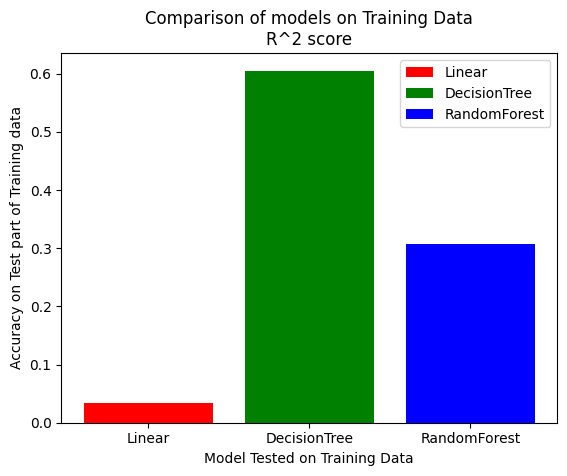

Best model is: DecisionTree with score: 0.605298018856979


In [27]:
# plot score of each model on bar chart
def plotScore(modelNameList,models): 
    modelscoresList = [x.score(Xtest,Ytest) for x in models] # get score of each model
    plt.bar(modelNameList, modelscoresList,color=['red','green','blue'],label=modelNameList)
    plt.title("Comparison of models on Training Data\nR^2 score")
    plt.xlabel("Model Tested on Training Data")
    plt.ylabel("Accuracy on Test part of Training data")
    plt.legend()
    plt.show()
    maxScore = max(modelscoresList) # get max score
    modelIndexWithMaxScore = modelscoresList.index(maxScore)
    print(f"Best model is: {modelNameList[modelIndexWithMaxScore]} with score: {maxScore}")
    return modelNameList[modelIndexWithMaxScore],maxScore

unoptimizedScore =  plotScore(["Linear","DecisionTree","RandomForest"],[AImodelLinear,AImodelDecision,AImodelForest]) # plot score of each model on bar chart

<h3>Considering Accuracy scores and training time we have selected Decision Tree Regression for our model</h3>

In [28]:
# make rolling window function
from sklearn.metrics import mean_absolute_error


def rollTheWindow(data,windowSize,AImodel,PrintResults=False):#here we are defining the rollingWindow function
    datasetLength = len(data) #length of data
    listOfPredictions = []
    numberOfWindows = datasetLength//windowSize
    index = 0
    lastWindow = False
    for i in range(numberOfWindows):#setting the lower and upper limits for the window size
        rollingWindow = []
        lowerLimit = index
        upperLimit = index+windowSize
        if upperLimit > datasetLength:
            upperLimit = datasetLength-1
        if lowerLimit >= upperLimit:
            break
        rollingWindow.append(data[lowerLimit:upperLimit])
        rollingWindow = pd.concat(rollingWindow)
        X_WINDOW_INPUT = rollingWindow[FEATURES]#setting the Machine's input
        Y_WINDOW_OUTPUT = rollingWindow['supply_demand']#setting the Machine's output
        currentPrediction = AImodel.predict(X_WINDOW_INPUT)#Machine predicting the ouput
        meanSqError = mean_squared_error(Y_WINDOW_OUTPUT, currentPrediction)#calculating the error based on actual and predicted output
        meanAbError = mean_absolute_error(Y_WINDOW_OUTPUT, currentPrediction)
        if PrintResults:
            print(f"Prediction for window [{lowerLimit},{upperLimit}] MSE={meanSqError} MAE={meanAbError}")
        predictionTuple = (lowerLimit,upperLimit,currentPrediction,meanSqError,Y_WINDOW_OUTPUT,meanAbError)
        listOfPredictions.append(predictionTuple)
        index = upperLimit + 1
        if index >= datasetLength-1 and lastWindow == False:#conditions which test validity of prediction based on window
            lastWindow = True
            index = datasetLength-1
        elif index >= datasetLength-1 and lastWindow == True:
            break
    maxSqError= max(listOfPredictions, key=lambda item: item[3])#printing the data
    minSqEror = min(listOfPredictions, key=lambda item: item[3])
    maxAbError= max(listOfPredictions, key=lambda item: item[5])
    minAbEror = min(listOfPredictions, key=lambda item: item[5])
    print(f"Max MSE={maxSqError[3]} MAE={maxAbError[5]}")
    print(f"Min MSE={minSqEror[3]} MAE={minAbEror[5]}")
    print("Average MSE ",np.mean([x[3] for x in listOfPredictions]))
    print("Average MAE ",np.mean([x[5] for x in listOfPredictions]))
    return listOfPredictions,maxSqError,minSqEror,maxAbError,minAbEror

In [29]:
def plotMSE(listOfPredictions):#plotting the Mean Square Error
    MSElist =[x[3] for x in listOfPredictions] # getting the MSE from the list of predictions
    plt.plot(MSElist,label="MSE")
    plt.title("Rolling window scores\nMean Squared Error")
    plt.xlabel("Window Number")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.show()
    return

def plotMAE(listOfPredictions):#plotting the Mean Absolute Error
    MAElist =[x[5] for x in listOfPredictions] # getting the MAE from the list of predictions
    plt.plot(MAElist,label="MAE")
    plt.title("Rolling window scores\nMean Absolute Error")
    plt.xlabel("Window Number")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.show()
    return

def plotRollingScores(listOfPredictions):#plotting the rollingScore using the previous two functions
    plotMSE(listOfPredictions)
    plotMAE(listOfPredictions)
    return
    
windowResult = rollTheWindow(orderData,1000,AImodelDecision) #calling the rollingWindow function on training data
# plotRollingScores(windowResult[0])

Max MSE=401354.94430325605 MAE=586.7410438278287
Min MSE=4.486828521398987 MAE=1.5294451520990033
Average MSE  2420.545024755845
Average MAE  17.147841621921106


<h1 style="background-color:green;">Model Optimization</h1>

In [30]:
def plotFeatureImportance(model,XtrainData):#comparing the importance of features through a bar plot for each feature
    featureImportanceFromModel = model.feature_importances_ # feature importance
    featureNames = XtrainData.columns   # getting the features
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    ax.bar(featureNames,featureImportanceFromModel)
    plt.title("Feature Importance Comparison Graph")
    plt.xlabel("Feature")
    plt.ylabel("Importance of Feature")
    return

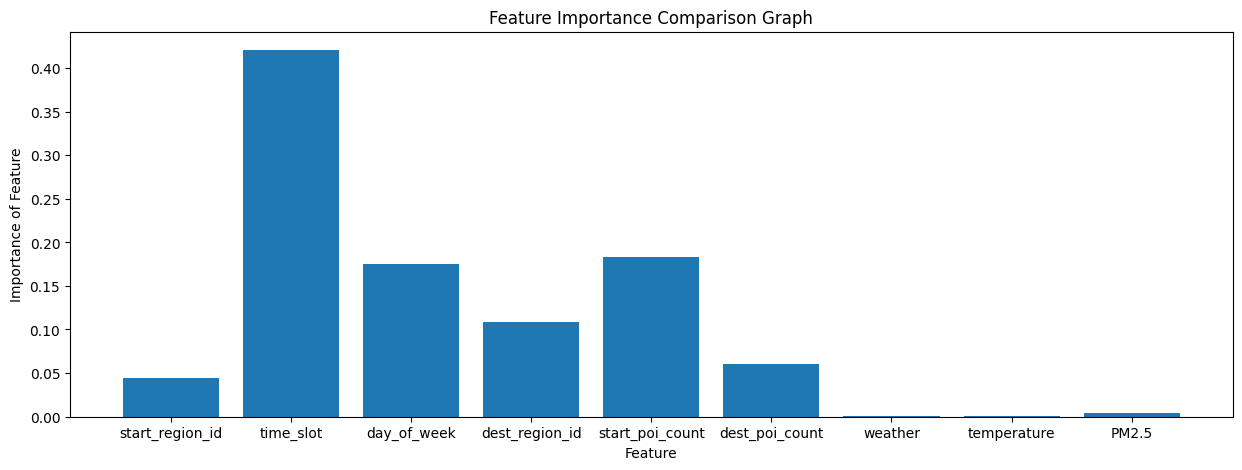

In [31]:
plotFeatureImportance(AImodelDecision,Xtrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters are: {'max_depth': 200, 'max_features': 9}
Optimized score: 0.95353271567637


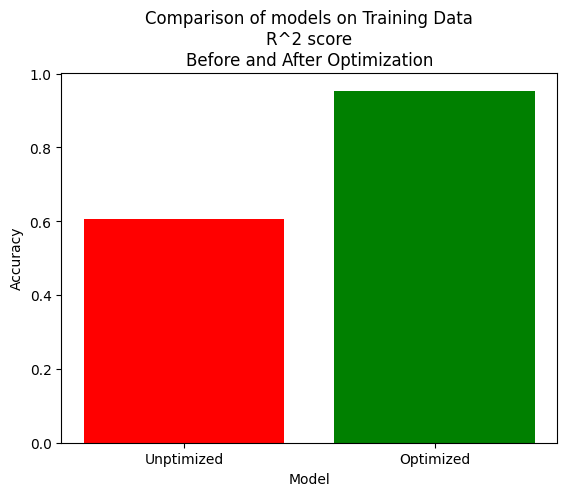

In [32]:
# optimize model here using grid search
from sklearn.model_selection import GridSearchCV

param_grid_for_random_search = {
    'max_depth': [10, 50, 100 ,200],
    'max_features': [3,6,9]
}

X = m[FEATURES]#all of the columns obtained from the training dataset
Y = m['supply_demand']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=0.001, random_state=30)#splitting the data set

AImodelDecision = DecisionTreeRegressor()   # creating the decision tree regression object

grid_search = GridSearchCV(estimator = AImodelDecision, param_grid = param_grid_for_random_search,cv=5,n_jobs=-1,verbose=5,scoring='neg_mean_absolute_error')   # performing the grid search
grid_search.fit(Xtrain,Ytrain) #fitting the grid with the data we have collected and separated Xtrain and Ytrain
bestParameters = grid_search.best_params_   # get best parameters
print(f"Best parameters are: {bestParameters}")

AImodelDecision = DecisionTreeRegressor(max_depth=bestParameters['max_depth'],max_features=bestParameters['max_features'])  # create model with best parameters
AImodelDecision.fit(Xtrain,Ytrain)  # fit model

optimizedScore = AImodelDecision.score(Xtest,Ytest) # get score of model
print(f"Optimized score: {optimizedScore}")
plt.bar(["Unptimized","Optimized"],[unoptimizedScore[1],optimizedScore],color=["red","green"])
plt.title("Comparison of models on Training Data\nR^2 score\nBefore and After Optimization")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

In [33]:
output = rollTheWindow(orderData,1000,AImodelDecision) # calling the rolling window function on training data with optimized model

Max MSE=438.741 MAE=10.701
Min MSE=0.0 MAE=0.0
Average MSE  0.14936659617190853
Average MAE  0.0036865182371788943


<h1 style="background-color:blue">Read Test Data</h1>

In [34]:
# read test data
# read region Data
regionTestData = pd.read_csv('./test_set/cluster_map/cluster_map', sep='\t', names=['region_hash', 'region_id'],dtype={'region_hash': 'str', 'region_id': 'int'}) #defining the column names and data types to extract data for
print(regionTestData.head())
#regionData.to_csv('regionData.csv',index=False)

                        region_hash  region_id
0  90c5a34f06ac86aee0fd70e2adce7d8a          1
1  f2c8c4bb99e6377d21de71275afd6cd2          2
2  58c7a4888306d8ff3a641d1c0feccbe3          3
3  b26a240205c852804ff8758628c0a86a          4
4  4b9e4cf2fbdc8281b8a1f9f12b80ce4d          5


In [35]:
# read order data
dataTypes = {'order_id':'str', 'driver_id':'str','start_region_hash':'str', 'dest_region_hash':'str' ,'time':'str'}#defining the column names and data types to extract data for
orderDataPath = './test_set/order_data/' #path to the folder
orderTestData = readMultipleData(orderDataPath,'test_order', ['order_id', 'driver_id', 'start_region_hash','dest_region_hash','time'], dataTypes,delimiter2=",") #reading multiple files in the directory
print("printing order data")
print(orderTestData.head())

5 files read
printing order data
                           order_id                         driver_id   
0  a903b5f7f65f1dc7f4ee94fec74673be  dce1e90fc91ed39a7b04a22d02910a7d  \
1  b7c838beaf12a2132776a1f00e016038  1f39eba5ce330f20c95177826a122e12   
2  0e0d3c93298ed59281352e34c6f1ec5a  8e4e2bc0342b3c55edea2723f6613e36   
3  1f6d0d7f68f216c4333969d6152a0a8b  5a33393e516673c8e9a065915667a30f   
4  bcf6050d9f5b270f8beb3ff80b01b435  f0232b8e45abc5ca92ca0f90fa811e7c   

                  start_region_hash                  dest_region_hash   
0  d4ec2125aff74eded207d2d915ef682f  d4ec2125aff74eded207d2d915ef682f  \
1  2407d482f0ffa22a947068f2551fe62c  2407d482f0ffa22a947068f2551fe62c   
2  b26a240205c852804ff8758628c0a86a  3a43dcdff3c0b66b1acb1644ff055f9d   
3  4725c39a5e5f4c188d382da3910b3f3f  4725c39a5e5f4c188d382da3910b3f3f   
4  dd8d3b9665536d6e05b29c2648c0e69a  a5609739c6b5c2719a3752327c5e33a7   

                  time  
0  2016-01-23 07:20:52  
1  2016-01-23 13:08:17  
2  2016-01-23 

In [36]:
# read weather data
dataTypes={'time':'str', 'weather':'int', 'temperature':'double', 'PM2.5':'double'} #defining the column names and data types to extract data for
weatherTestDataPath = './test_set/weather_data/'#path to the data
weatherTestData = readMultipleData(weatherTestDataPath,'weather_data', ['time', 'weather', 'temperature', 'PM2.5'], dataTypes)#reading the multiple files in the driectory
print("printing weather data")
print(weatherTestData.head())

5 files read
printing weather data
                  time  weather  temperature  PM2.5
0  2016-01-23 07:01:12        4          1.0   94.0
1  2016-01-23 11:14:04        3         -1.0  107.0
2  2016-01-23 13:16:44        3         -1.0   56.0
3  2016-01-23 15:02:02        3          0.0   48.0
4  2016-01-23 15:16:39        3          0.0   48.0


In [37]:
#pre processing weather Test Data based on weather timeSlot 
weatherTestData['time_slot'] = weatherTestData['time'].apply(calculateTimeSlot,printValue=False) # extracting time slot
weatherTestData['date'] = weatherTestData['time'].apply(extractDate) # extracting date
# weatherData['day_of_week'] = weatherData['time'].apply(extractDayOfWeek)
weatherTestData = weatherTestData.drop(['time'], axis=1)
print(weatherTestData.head())

   weather  temperature  PM2.5  time_slot        date
0        4          1.0   94.0         43  2016-01-23
1        3         -1.0  107.0         68  2016-01-23
2        3         -1.0   56.0         80  2016-01-23
3        3          0.0   48.0         91  2016-01-23
4        3          0.0   48.0         92  2016-01-23


In [38]:
orderTestData = pd.merge(regionTestData,orderTestData, how='inner', right_on='start_region_hash', left_on='region_hash') # merging the region data with order data
print("Step 1 done")
orderTestData = orderTestData.rename(columns={'region_id': 'start_region_id'})
orderTestData = pd.merge(regionTestData,orderTestData, how='inner', right_on='dest_region_hash', left_on='region_hash') # merging the region data with order data
orderTestData = orderTestData.rename(columns={'region_id': 'dest_region_id'})
print("Step 2 done")
orderTestData['time_slot'] = orderTestData['time'].apply(calculateTimeSlot,printValue=False) # extracting time slot
print("Step 3 done")
orderTestData['day_of_week'] = orderTestData['time'].apply(extractDayOfWeek) # extracting day of week
print("Step 4 done")
orderTestData['date'] = orderTestData['time'].apply(extractDate) # extracting date
print("Step 5 done")
orderTestData = orderTestData.drop(['dest_region_hash','start_region_hash'], axis=1) # dropping the extra columns
print("Step 6 done")
# orderTestData['time_part'] = orderTestData['time'].apply(extractTime)
print(orderTestData.head())

Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  31bcca3b90b4d971697156b63900d514  172b54135139345fb9d24d0b23635387  \
1  cca7aca7134cffb46957d59897dcdbbc  773dd49e4148d807b099b42372fd5ac7   
2  85cbab6eaea4b6bf1bc2cd7ce6701a93  75eb

In [39]:
# read POI Data
poiDataStr = { #the structure of data we will obtain poi file
    'region_hash':[],#the region hash
    'poi_class':[] #the poi class list
}
with open('./test_set/poi_data/poi_data','r') as fileToRead: # reading the file line by line
    for line in fileToRead:
        line = line.strip()
        columns = line.split('\t')  # splitting the line based on tab space
        poiDataStr['region_hash'].append(columns[0])
        remData = columns[1:]                       # extracting the poi class as remaining data
        poiDataStr['poi_class'].append(remData)
        
poiTestData = pd.DataFrame(poiDataStr,columns=['region_hash','poi_class'])
poiTestData['poi_count'] = poiTestData['poi_class'].apply(extractNumberOfPOI)   # extracting the number of POI
poiTestData = pd.merge(regionTestData,poiTestData, how='inner', on='region_hash') # merging the region data with POI data
poiTestData = poiTestData.drop(['region_hash'], axis=1)
poiTestData = poiTestData.drop(['poi_class'], axis=1)
print(poiTestData.head())

   region_id  poi_count
0          1     653376
1          2     343537
2          3      31125
3          4     187829
4          5      27888


In [40]:
# calculating the number of requests
orderTestData['requests'] = 1   # adding a column to count the number of requests with initial value as 1 #setting the column 'requests' equal to 1
# print(orderData.head())
groupedTestMergedData = orderTestData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['requests'].agg('sum').reset_index() #grouping the dataframe  based on the sum of the requests column
# groupedMergedData = groupedMergedData.drop(['date','region_hash','order_id','driver_id','time'], axis=1)
orderTestData = pd.merge(orderTestData,groupedTestMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id']) # merge data for sum
print(orderTestData.head())

                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  31bcca3b90b4d971697156b63900d514  172b54135139345fb9d24d0b23635387  \
1  cca7aca7134cffb46957d59897dcdbbc  773dd49e4148d807b099b42372fd5ac7   
2  85cbab6eaea4b6bf1bc2cd7ce6701a93  75eb96caaa6bacb30b810996d655dd54   
3  50f3588c595eca21e6be6182d521decc  c7b

In [41]:
orderTestData = orderTestData.drop(["requests_x"], axis=1)          # dropping the extra columns#dropping the column 'request_x' and renaming the columns
orderTestData = orderTestData.drop(["region_hash_x"], axis=1)#dropping the 'region_hash_x' column
orderTestData = orderTestData.rename(columns={"region_hash_y": "region_hash"})#renaming the columns
orderTestData = orderTestData.rename(columns={"requests_y": "requests"})
print(orderTestData.head())

   dest_region_id                       region_hash  start_region_id   
0               1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  31bcca3b90b4d971697156b63900d514  172b54135139345fb9d24d0b23635387  \
1  cca7aca7134cffb46957d59897dcdbbc  773dd49e4148d807b099b42372fd5ac7   
2  85cbab6eaea4b6bf1bc2cd7ce6701a93  75eb96caaa6bacb30b810996d655dd54   
3  50f3588c595eca21e6be6182d521decc  c7bddad06fdf4fd7bb77c3007118d215   
4  3c751c264452c4d73e90dd6066566e94  54402bda533bb92ec3d697c361ca683d   

                  time  time_slot  day_of_week        date  requests  
0  2016-01-23 19:09:39        116            5  2016-01-2

In [42]:
orderTestData['temp'] = 1#setting the 'temp' column to 1   # add temp column to count the number of answers
orderTestData['answers'] = orderTestData['temp'].where(orderTestData['driver_id'].notnull(), 0)#ordering the 'temp' column by 'driver_id' where it isn't null # if driver id is not null then 1 else 0
orderTestData = orderTestData.drop(['temp'], axis=1)#dropping the  'temp column'
groupedTestMergedData = orderTestData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['answers'].agg('sum').reset_index() # group and sum
orderTestData = pd.merge(orderTestData,groupedTestMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id']) # merge data for sum
print(orderTestData)

        dest_region_id                       region_hash  start_region_id   
0                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                ...                               ...              ...   
467906              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467907              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467908              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467909              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467910              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                order_id                         driver_id 

In [43]:
orderTestData = orderTestData.drop(["answers_x"], axis=1)       # dropping the extra columns and renaming the columns
orderTestData = orderTestData.rename(columns={"answers_y": "answers"})
# orderTestData.to_csv('mergedOrderData.csv',index=False)

In [44]:
# orderTestData['supply_demand'] = orderTestData['requests'] - orderTestData['answers']
orderTestData['supply_demand'] = orderTestData['requests']
print(orderTestData)

        dest_region_id                       region_hash  start_region_id   
0                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                ...                               ...              ...   
467906              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467907              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467908              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467909              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467910              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                order_id                         driver_id 

In [45]:
orderTestData = orderTestData.drop(['order_id','driver_id','requests','answers','region_hash','time'], axis=1)  # dropping the extra columns
print(orderTestData)

        dest_region_id  start_region_id  time_slot  day_of_week        date   
0                    1                1        116            5  2016-01-23  \
1                    1                1        127            5  2016-01-23   
2                    1                1         43            5  2016-01-23   
3                    1                1         81            5  2016-01-23   
4                    1                1         93            5  2016-01-23   
...                ...              ...        ...          ...         ...   
467906              66               66         69            6  2016-01-31   
467907              66               66        104            6  2016-01-31   
467908              66               66        103            6  2016-01-31   
467909              66               66         57            6  2016-01-31   
467910              66               66         92            6  2016-01-31   

        supply_demand  
0                 130  
1  

In [46]:
orderTestData = pd.merge(orderTestData,poiData, how="inner", left_on='start_region_id', right_on='region_id') # merging the region data with POI data
orderTestData = orderTestData.rename(columns={"poi_count": "start_poi_count"}) # renaming the column
orderTestData = pd.merge(orderTestData,poiData, how="inner", left_on='dest_region_id',right_on='region_id') # merging the region data with POI data
orderTestData = orderTestData.rename(columns={"poi_count": "dest_poi_count"}) # renaming the column
orderTestData = orderTestData.drop(['region_id_x','region_id_y'], axis=1)
print(orderTestData)

        dest_region_id  start_region_id  time_slot  day_of_week        date   
0                    1                1        116            5  2016-01-23  \
1                    1                1        127            5  2016-01-23   
2                    1                1         43            5  2016-01-23   
3                    1                1         81            5  2016-01-23   
4                    1                1         93            5  2016-01-23   
...                ...              ...        ...          ...         ...   
467906              63               63         79            2  2016-01-27   
467907              63               63         56            2  2016-01-27   
467908              63               63         68            4  2016-01-29   
467909              63               63         68            4  2016-01-29   
467910              63               63         57            4  2016-01-29   

        supply_demand  start_poi_count  dest_poi_co

In [47]:
orderTestData = pd.merge(weatherTestData,orderTestData, how="inner", on=['date','time_slot']) # merging the weather data with order data
print(orderTestData)


        weather  temperature  PM2.5  time_slot        date  dest_region_id   
0             4          1.0   94.0         43  2016-01-23               1  \
1             4          1.0   94.0         43  2016-01-23               1   
2             4          1.0   94.0         43  2016-01-23               1   
3             4          1.0   94.0         43  2016-01-23               1   
4             4          1.0   94.0         43  2016-01-23               1   
...         ...          ...    ...        ...         ...             ...   
288877        8          1.0   69.0        141  2016-01-31              49   
288878        8          1.0   69.0        141  2016-01-31              64   
288879        8          1.0   69.0        141  2016-01-31              64   
288880        8          1.0   69.0        141  2016-01-31              32   
288881        8          1.0   69.0        141  2016-01-31              17   

        start_region_id  day_of_week  supply_demand  start_poi_

In [48]:
# mTest = orderTestData.drop_duplicates(keep='first')
mTest = orderTestData.copy()    # copying the dataframe
mTest = mTest.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['supply_demand'].agg('mean').reset_index() # grouping and mean to remove duplicates
# mTest = mTest.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'],keep='first')
print(mTest)

       start_region_id  time_slot  day_of_week  dest_region_id   
0                    1         43            2               1  \
1                    1         43            2               8   
2                    1         43            2              21   
3                    1         43            2              36   
4                    1         43            2              42   
...                ...        ...          ...             ...   
34127               66        141            0              66   
34128               66        141            2              66   
34129               66        141            4              66   
34130               66        141            5              66   
34131               66        141            6              66   

       start_poi_count  dest_poi_count  weather  temperature  PM2.5   
0               653376          653376        3          3.0   76.0  \
1               653376         1518402        3          3.0   76

<h1 style="background-color:orange; color:black;">Prediction on Test Data</h1>

In [49]:
listOfPredictions =  rollTheWindow(mTest,1000,AImodelDecision,PrintResults=True) # calling the function on the test data

Prediction for window [0,1000] MSE=797.473 MAE=11.815
Prediction for window [1001,2001] MSE=31.607 MAE=3.289
Prediction for window [2002,3002] MSE=45.376 MAE=3.22
Prediction for window [3003,4003] MSE=164.319 MAE=6.707
Prediction for window [4004,5004] MSE=344.498 MAE=8.372
Prediction for window [5005,6005] MSE=419.778 MAE=9.948
Prediction for window [6006,7006] MSE=24.642 MAE=2.808
Prediction for window [7007,8007] MSE=245.883 MAE=6.491
Prediction for window [8008,9008] MSE=154.574 MAE=5.72
Prediction for window [9009,10009] MSE=49.325 MAE=4.075
Prediction for window [10010,11010] MSE=11.202 MAE=2.088
Prediction for window [11011,12011] MSE=136.473 MAE=5.697
Prediction for window [12012,13012] MSE=225.479 MAE=8.311
Prediction for window [13013,14013] MSE=269.782 MAE=6.844
Prediction for window [14014,15014] MSE=485.56 MAE=9.742
Prediction for window [15015,16015] MSE=169.682 MAE=5.984
Prediction for window [16016,17016] MSE=72.06 MAE=4.306
Prediction for window [17017,18017] MSE=51.64

In [50]:
Xtest = mTest[FEATURES] # extracting the features
Ytest = mTest['supply_demand'] # extracting the target
print("Accuracy of the model is: ",AImodelDecision.score(Xtest,Ytest))

Accuracy of the model is:  0.501346567910171


<h1 style="background-color:orange; color:black">Plot actual gap and predicted gap against time</h1>

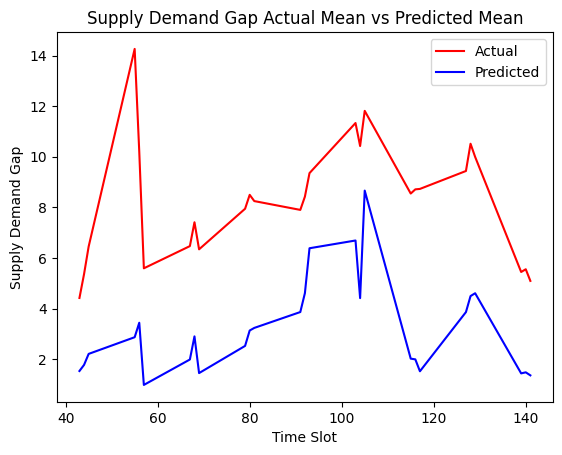

In [51]:
fXTest = mTest.copy()
fYTest = fXTest['supply_demand']
fXTest['predicted'] = AImodelDecision.predict(fXTest[FEATURES]) # predicting the values
groupedfXTestSupply = fXTest.groupby(['time_slot'])['supply_demand'].agg('mean').reset_index() # mean of the supply demand
groupedfXTestPredicted = fXTest.groupby(['time_slot'])['predicted'].agg('mean').reset_index() # mean of the predicted values

plt.plot(groupedfXTestSupply['time_slot'],groupedfXTestSupply['supply_demand'],label='Actual',color='red') # plotting the graph for actual and predicted values
plt.plot(groupedfXTestPredicted['time_slot'],groupedfXTestPredicted['predicted'],label='Predicted',color='blue') 
plt.xlabel('Time Slot')
plt.ylabel('Supply Demand Gap')
plt.title('Supply Demand Gap Actual Mean vs Predicted Mean')
plt.legend()

<h1 style="background-color:orange; color:black;">Actual Values and Mean Predicted Values against rows(index)</h1>

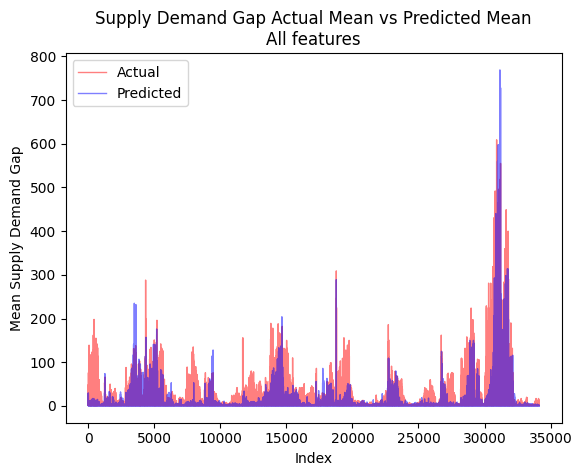

In [52]:
zXTest = mTest.copy()
zYTest = zXTest['supply_demand']
zXTest['predicted'] = AImodelDecision.predict(zXTest[FEATURES]) # predicting the values
# plotting the actual values and the mean predicted values

#groupedzXTestSupply = zXTest.groupby(['time_slot'])['supply_demand'].agg('mean').reset_index()
groupedzXTestSupply = zXTest.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['supply_demand'].agg('mean').reset_index() # mean of the supply demand
groupedzXTestPredicted = zXTest.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['predicted'].agg('mean').reset_index() # mean of the predicted values

xRange = range(0,groupedzXTestSupply.shape[0]) # range of the values i.e window index
plt.plot(xRange,groupedzXTestSupply['supply_demand'],label='Actual',color='red',alpha=0.5,linewidth=1) # plotting the graph for actual and predicted values
plt.plot(xRange,groupedzXTestPredicted['predicted'],label='Predicted',color='blue',alpha=0.5,linewidth=1)
plt.xlabel('Index')
plt.ylabel('Mean Supply Demand Gap')
plt.title('Supply Demand Gap Actual Mean vs Predicted Mean\nAll features')
plt.legend()
plt.show()

<h1 style="background-color:orange; color:black;">Plotting Error against window for Test data</h>

Max MSE=2018.91 MAE=20.01
Min MSE=1.62 MAE=1.0
Average MSE  235.79358239959717
Average MAE  6.035147299509002


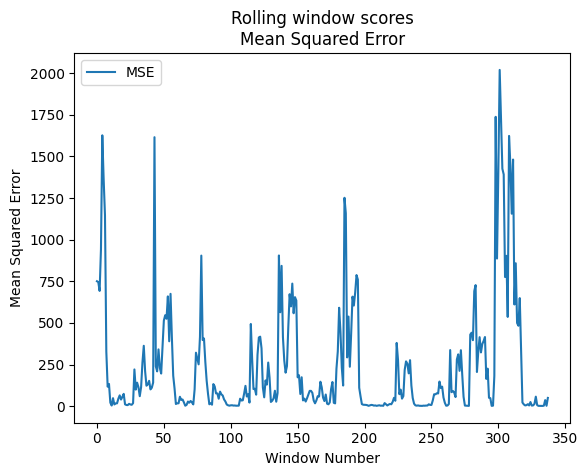

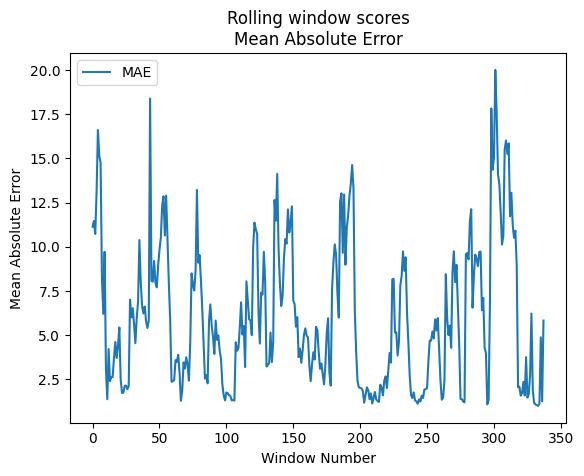

In [53]:
windowData = rollTheWindow(mTest,100,AImodelDecision,PrintResults=False) # applying the rolling Window function
plotRollingScores(windowData[0])#here we plot the result

In [54]:
predictions = AImodelDecision.predict(mTest[FEATURES]) #storing the predictions made by the AI model based on the features data
totalMeanAbsError = mean_absolute_error(mTest['supply_demand'],predictions) # calculating the mean absolute error #calculating the mean absolute error
totalMeanSqError = mean_squared_error(mTest['supply_demand'],predictions) # calculating the mean squared error #calculating the mean squared error
print("Total MAE: ",totalMeanAbsError)#printing the error 
print("Total MSE: ",totalMeanSqError)

Total MAE:  6.046202976678776
Total MSE:  238.62313957576467
